# Задача прогнозирования оттока клиентов

По историческим данным о поведение клиентов и расторжении договоров спрогнозируем уйдет ли клиент в ближайшее время.  
Метрикой будет F1-мера

# 1. Подготовим данные

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv(r'C:\Users\Nikolay\My_DS_projects\datasets\Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Есть пропуски в поле Tenure (количество недвижимости), что можно интерпретировать как 0/отсутствие недвижимости, но мы будем считать пропуски буквальным отсутствием информации и зменим их медианой (судя по квартилям распределение нормальное, среднее и медиана равны).
Также приведем это поле к целочисленному типу данных.

In [5]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median()).astype('int')

Проверим наличие дублирующих строк по id клиента.

In [6]:
print('Количество дублирующих строка:',len(data[data['CustomerId'].duplicated() == True]))

Количество дублирующих строка: 0


Хорошо, дублирующих строк нет.  
Поля RowNumber и CusomerId являются количественными, но не подходят на роль признаков и будут мешать нам в дальнейшем при построении модели. Так же мы будем кодировать категорийные переменные и паременная Surname нам будет не нужна. Удалим их.

In [7]:
data = data.drop(['RowNumber','CustomerId','Surname'], axis = 1)

Применим метод прямого кодирования для категорийных переменных 

In [8]:
data = pd.get_dummies(data, drop_first = True)

In [9]:
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Разделим данные на features и target

In [10]:
features = data.drop('Exited',axis = 1)
target = data['Exited']

Разделим данные на обучающую, валидационную и тестовую выборки (соотношение 60/20/20)

In [11]:
# 60% строк - в обучающую выборку
features_train, features_else, target_train, target_else = train_test_split(features, target, test_size = 0.4, random_state = 12345)
# оставшиеся (40% от общего датасета) делим пополам
features_valid, features_test, target_valid, target_test = train_test_split(features_else, target_else, test_size = 0.5, random_state = 12345)

Приведем признаки к одному масштабу, для настройки масштабирования возьмем обучающие данные

In [12]:
numeric = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']
scaler = StandardScaler()
#настравиваем по обучающей выборке
scaler.fit(features_train[numeric])
#масштабируем в обучающей, валидационной и тестовых выборках
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

# 2. Исследуем задачу

Баланс классов

In [13]:
data['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Значений Exited=1 меньше в 4 раза

Обучим несколько моделей игнорируя дисбаланс классов

#### Дерево решений

In [14]:
tree_model_result = []
for d in range(1,20,2):
    for s in range(2,30,2):
        for l in range(2,30,2):
            model = DecisionTreeClassifier(random_state=12345, max_depth=d, min_samples_split=s, min_samples_leaf=l)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            f1 = f1_score(target_valid, predictions)
            tree_model_result.append([d,s,l,f1])
tree_model_result_df = pd.DataFrame(data=tree_model_result)
tree_model_result_df.columns = ['max_depth','min_samples_split','min_samples_leaf','f1']
tree_model_result_df.sort_values('f1', ascending=False).head()

,max_depth,min_samples_split,min_samples_leaf,f1
910,9,20,2,0.577201
896,9,18,2,0.576369
826,9,8,2,0.575107
882,9,16,2,0.572662
812,9,6,2,0.572662


#### Случайный лес

Переберем гиперпараметры

In [15]:
forest_model_result = []
for d in range(1,20,2):
    for s in range(2,30,2):
        for l in range(2,30,2):
            model = RandomForestClassifier(random_state=12345, max_depth=d, min_samples_split=s, min_samples_leaf=l)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            f1 = f1_score(target_valid, predictions)
            forest_model_result.append([d,s,l,f1])
forest_model_result_df = pd.DataFrame(data=forest_model_result)
forest_model_result_df.columns = ['max_depth','min_samples_split','min_samples_leaf','f1']
forest_model_result_df.sort_values('f1', ascending=False).head()

,max_depth,min_samples_split,min_samples_leaf,f1
1470,15,16,2,0.602410
1486,15,18,6,0.602374
1304,13,20,6,0.601770
798,9,4,2,0.601504
784,9,2,2,0.601504


Теперь переберем количество деревьев

In [16]:
forest_model_result = []
for e in range(1,100,5):
    model = RandomForestClassifier(random_state=12345, n_estimators = e, max_depth=15, min_samples_split=16, min_samples_leaf=2)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions)
    forest_model_result.append([e,f1])
forest_model_result_df = pd.DataFrame(data=forest_model_result)
forest_model_result_df.columns = ['n_estimators','f1']
forest_model_result_df.sort_values('f1', ascending=False).head()

,n_estimators,f1
2,11,0.591806
13,66,0.586626
17,86,0.586626
19,96,0.586260
3,16,0.584992


#### Логистическая регрессия

In [17]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
f1 = f1_score(target_valid, predictions)
print('f1 score =', f1)

f1 score = 0.33108108108108103


Наибольшее значение f1 мы получили используя алгоритм случайный лес с параметрами:  
- n_estimators = 11
- max_depth = 15
- min_samples_split = 16
- min_samples_leaf = 2

Проверим данную модель на тестовой выборке

In [18]:
model = RandomForestClassifier(random_state=12345, n_estimators = 11, max_depth=15, min_samples_split=16, min_samples_leaf=2)
model.fit(pd.concat([features_train,features_valid]), pd.concat([target_train,target_valid]))
predictions = model.predict(features_test)
f1 = f1_score(target_test, predictions)
print('Значение f1 =',f1)

Значение f1 = 0.5468277945619336


Недостаточно хорошо

# 3. Убираем дисбаланс классов

Мы помним что у нас в целевых признаках объектов с значением 1 в четыре разам меньше чем с значением 0. Для учета дисбаланса попробуем три метода:
- параметр class_weight = 'balanced'
- апсемплинг
- изменение порога классификации

#### Случайный лес с параметром class_weight = 'balanced'

In [19]:
# перебираем гиперпараметры
forest_model_result = []
for d in range(1,20,2):
    for s in range(2,30,2):
        for l in range(2,30,2):
            model = RandomForestClassifier(random_state = 12345, max_depth =d , min_samples_split = s, min_samples_leaf = l, class_weight = 'balanced')
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            f1 = f1_score(target_valid, predictions)
            forest_model_result.append([d,s,l,f1])
forest_model_result_df = pd.DataFrame(data=forest_model_result)
forest_model_result_df.columns = ['max_depth','min_samples_split','min_samples_leaf','f1']
forest_model_result_df.sort_values('f1', ascending=False).head()

,max_depth,min_samples_split,min_samples_leaf,f1
828,9,8,6,0.637931
814,9,6,6,0.637931
786,9,2,6,0.637931
856,9,12,6,0.637931
800,9,4,6,0.637931


In [20]:
# подбираем значение n_estimators
forest_model_result = []
for e in range(1,100,5):
    model = RandomForestClassifier(random_state=12345, n_estimators = e, max_depth=9, min_samples_split=8, min_samples_leaf=6, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions)
    forest_model_result.append([e,f1])
forest_model_result_df = pd.DataFrame(data=forest_model_result)
forest_model_result_df.columns = ['n_estimators','f1']
forest_model_result_df.sort_values('f1', ascending=False).head()

,n_estimators,f1
18,91,0.641304
9,46,0.640860
19,96,0.640523
17,86,0.637650
16,81,0.636957


Наилучший показатель f1 получается при параметрах n_estimators = 91, max_depth=9, min_samples_split=8, min_samples_leaf=6

#### Логистическая регрессия с параметром class_weight = 'balanced'

In [21]:
model = LogisticRegression(random_state = 12345, class_weight = 'balanced')
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
f1 = f1_score(target_valid, predictions)
print('f1 score =', f1)

f1 score = 0.4888507718696398


#### Логистическая регрессия с апсемплингом обучающей выборки

In [22]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)    
    return features_upsampled, target_upsampled

In [23]:
for i in range(1,6):
    features_upsampled, target_upsampled = upsample(features_train, target_train, i)
    model = LogisticRegression(random_state=12345)
    model.fit(features_upsampled,target_upsampled)
    predicted = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted)
    print('При увеличении в обучающей выборке положительных записей в ',i,'раз, f1 score =', f1)

При увеличении в обучающей выборке положительных записей в  1 раз, f1 score = 0.33108108108108103
При увеличении в обучающей выборке положительных записей в  2 раз, f1 score = 0.46437346437346433
При увеличении в обучающей выборке положительных записей в  3 раз, f1 score = 0.5
При увеличении в обучающей выборке положительных записей в  4 раз, f1 score = 0.4888507718696398
При увеличении в обучающей выборке положительных записей в  5 раз, f1 score = 0.4847094801223242


При апсемплинге в 4 раза получается значение f1 которое мы получили ранее используя параметр class_weight = 'balanced'.
Проверим как влияет апсемплинг в алгоритме случайного леса

#### Случайный лес с апсемплингом обучающей выборки

In [24]:
for i in range(1,6):
    features_upsampled, target_upsampled = upsample(features_train, target_train, i)
    model = RandomForestClassifier(random_state=12345, n_estimators = 91, max_depth=9, min_samples_split=8, min_samples_leaf=6)
    model.fit(features_upsampled,target_upsampled)
    predicted = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted)
    print('При увеличении в обучающей выборке положительных записей в ',i,'раз, f1 score =', f1)

При увеличении в обучающей выборке положительных записей в  1 раз, f1 score = 0.56875
При увеличении в обучающей выборке положительных записей в  2 раз, f1 score = 0.624
При увеличении в обучающей выборке положительных записей в  3 раз, f1 score = 0.6354285714285716
При увеличении в обучающей выборке положительных записей в  4 раз, f1 score = 0.6279792746113989
При увеличении в обучающей выборке положительных записей в  5 раз, f1 score = 0.599236641221374


#### Логистическая регрессия с измененым порогом классификации

In [25]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.6, 0.02):
    predicted = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted)
    recall = recall_score(target_valid, predicted)
    f1 = 2 * precision * recall / (precision + recall)
    print('При пороге =',threshold,' f1 =',f1)

При пороге = 0.0  f1 = 0.3457402812241522
При пороге = 0.02  f1 = 0.34847853272196744
При пороге = 0.04  f1 = 0.36865538735529835
При пороге = 0.06  f1 = 0.391072295002426
При пороге = 0.08  f1 = 0.4051948051948052
При пороге = 0.1  f1 = 0.4225352112676057
При пороге = 0.12  f1 = 0.4440344403444034
При пороге = 0.14  f1 = 0.46247464503042596
При пороге = 0.16  f1 = 0.4684554024655547
При пороге = 0.18  f1 = 0.4815106215578285
При пороге = 0.2  f1 = 0.4784446322907861
При пороге = 0.22  f1 = 0.4822565969062785
При пороге = 0.24  f1 = 0.49758919961427195
При пороге = 0.26  f1 = 0.4989816700610997
При пороге = 0.28  f1 = 0.4872881355932204
При пороге = 0.3  f1 = 0.4837625979843226
При пороге = 0.32  f1 = 0.4691943127962085
При пороге = 0.34  f1 = 0.46192259675405745
При пороге = 0.36  f1 = 0.4450261780104712
При пороге = 0.38  f1 = 0.4248275862068965
При пороге = 0.4  f1 = 0.3982683982683983
При пороге = 0.42  f1 = 0.38930163447251115
При пороге = 0.44  f1 = 0.3686635944700461
При пороге 

Наибольшего значения f1 удалось достичь используя алгоритм случайный лес с параметром class_weight = 'balanced'

# 4. Тестируем модель

Проверим нашу лучшую модель на тестовой выборке

Значение f1 = 0.6213592233009708


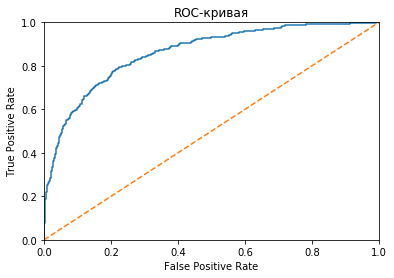

AUC-ROC = 0.8611317236096309


In [26]:
model = RandomForestClassifier(random_state=12345, n_estimators = 91, max_depth=9, min_samples_split=8, min_samples_leaf=6,class_weight='balanced')
model.fit(pd.concat([features_train,features_valid]), pd.concat([target_train,target_valid]))
predictions = model.predict(features_test)
f1 = f1_score(target_test, predictions)
print('Значение f1 =',f1)
probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
auc_roc = roc_auc_score(target_test,probabilities_one_valid)
print('AUC-ROC =',auc_roc)

### Общий вывод  
В рамках данного проекта мы подготовили данные, попробовали три алгоритма обучения, выбрали гиперпараметры и применили различные методы для работы с дисбалансом в классах.  
Наилучший результат показал алгоритм случайный лес и гиперпараметрами n_estimators = 91, max_depth=9, min_samples_split=8, min_samples_leaf=6, для балансировки классов мы использовали параметр модели class_weight='balanced'  
На тестовой выборке удалось достич значения f1 = 0.62